# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/beijing_pm2.5_data/test.csv')


In [4]:
# function to format code descriptions in the cells
def comment(text):
  description = print("==== " + text + " ====\n" )
  return description

In [10]:
# function to check the number and percentage of misssing values in any column
def check_missing_values(column):
  missing_values  = column.isnull().sum()

  missing_percent = (missing_values/len(train['pm2.5'])) * 100

  print (f'The number of missing values in the target column is {missing_values} which is {missing_percent:.2f}% of the records')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [5]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [6]:
# Inspecting test dataset
print("Testing Data Overview:\n")
test.head()

Testing Data Overview:



,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [7]:
comment('Shows list of training data columns.\n Now we know that each column has 9 features(excluding, datetime, the No column and the target variable) so this is a multivariate time series\n problem, and each timestep in our sequence will have values from these columns,\n we can assume it will be 9 features per timestep for now')
train.columns

==== Shows list of training data columns.
 Now we know that each column has 9 features(excluding, datetime, the No column and the target variable) so this is a multivariate time series
 problem, and each timestep in our sequence will have values from these columns,
 we can assume it will be 9 features per timestep for now ====



Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Dataset Column Definitions:
## **Target Variable**:

**pm2.5**: Fine particulate matter concentration (μg/m³), High values mean more pollution, values above 100μg/m³ are dangerous

## **Features**:

**DEWP**: Dew point temperature (°C) - humidity indicator.

**TEMP**: Air temperature (°C).

**PRES**: Atmospheric pressure (hPa).

**Iws**: Cumulated wind speed (m/s).

**Is**: Cumulated hours of snow


**Ir**: Cumulated hours of rain

**Wind Direction**:

**cbwd_NW**: Northwest wind indicator

**cbwd_SE**: Southeast wind indicator

**cbwd_cv**: Calm/variable wind indicator

In [8]:
comment("Gives a general overview of the dataset including the number of samples,\n number of columns non null entries in each column.\n We can immediately see that there are 30676 entries in the dataset\n and 12 columns total including the index,the target variable and the datetime variable.\n There are no null entries  in any of the columns except the pm2.5 column(our target variable)")
train.info()


==== Gives a general overview of the dataset including the number of samples,
 number of columns non null entries in each column.
 We can immediately see that there are 30676 entries in the dataset
 and 12 columns total including the index,the target variable and the datetime variable.
 There are no null entries  in any of the columns except the pm2.5 column(our target variable) ====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  floa

In [9]:
comment('Gives a general overview of the descriptive statistics in the target variable\n The mean is ~100.8 in the target variable, but with a large standard deviation (~93).\n The values range widely (0 up to 994) which means there is a potential for outliers.\n The interquartile range (29 - 142) is wide too so that data may have alot of fluctuations.')

train.describe()

==== Gives a general overview of the descriptive statistics in the target variable
 The mean is ~100.8 in the target variable, but with a large standard deviation (~93).
 The values range widely (0 up to 994) which means there is a potential for outliers.
 The interquartile range (29 - 142) is wide too so that data may have alot of fluctuations. ====



,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


In [12]:
comment("Checking for the number of null values in the target variable,\n Checking for missing values helps assess the quality of the data and informs preprocessing strategy")
check_missing_values(train['pm2.5'])

==== Checking for the number of null values in the target variable,
 Checking for missing values helps assess the quality of the data and informs preprocessing strategy ====

The number of missing values in the target column is 1921 which is 6.26% of the records


In [36]:
# check for all the columns with null values
train.query('`pm2.5` != `pm2.5`')

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2013-05-18 06:00:00,29599,0.774790,0.373119,-0.822670,-0.459890,-0.069353,-0.137667,-0.690542,-0.732019,1.915355,NaN
2013-05-18 07:00:00,29600,0.844074,0.537074,-0.822670,-0.415099,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,NaN
2013-05-28 13:00:00,29846,0.913358,0.783006,-1.114823,-0.200542,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


In [13]:
comment("This block of code ensures that the datetime column is actually in the correct datetime format\n and then shows the range of the dataset\n We can se that the code covers 30675 hours which corresponds to the total number of columns in the dataset\n. This confirms that the records in the dataset are taken an hour apart,\n spanning from 1st of January 2010 to the 2nd of July 2013")

# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Checks the range of the dataset in date(Start date to end date
print(f"Date range is from {train['datetime'].min()} to {train['datetime'].max()}\n")

# Displays the timespan of the dataset in hours
print(f" The total number of hours in the dataset is {(train['datetime'].max() - train['datetime'].min()).total_seconds()/3600} hours")



==== This block of code ensures that the datetime column is actually in the correct datetime format
 and then shows the range of the dataset
 We can se that the code covers 30675 hours which corresponds to the total number of columns in the dataset
. This confirms that the records in the dataset are taken an hour apart,
 spanning from 1st of January 2010 to the 2nd of July 2013 ====

Date range is from 2010-01-01 00:00:00 to 2013-07-02 03:00:00

 The total number of hours in the dataset is 30675.0 hours


In [14]:
# Save an original version of the dataset where the datetime column is not the index
train_non_indexed = train.copy()
train_non_indexed['datetime']= pd.to_datetime(train_non_indexed['datetime'])


In [15]:
# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)
train.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


# Visualisations

==== Shows a plot of PM2.5  vs time.
 The graph is blurry but it indicates the appearances of outliers and noise.
 Breaks in the line show the missing data in the target column.
 We can also get a sense that there is stationarity in the mean aroud 100.7 so  it suggests we don’t need heavy detrending or differencing
 just to “remove trend" in the data before passing it to the LSTM” ====



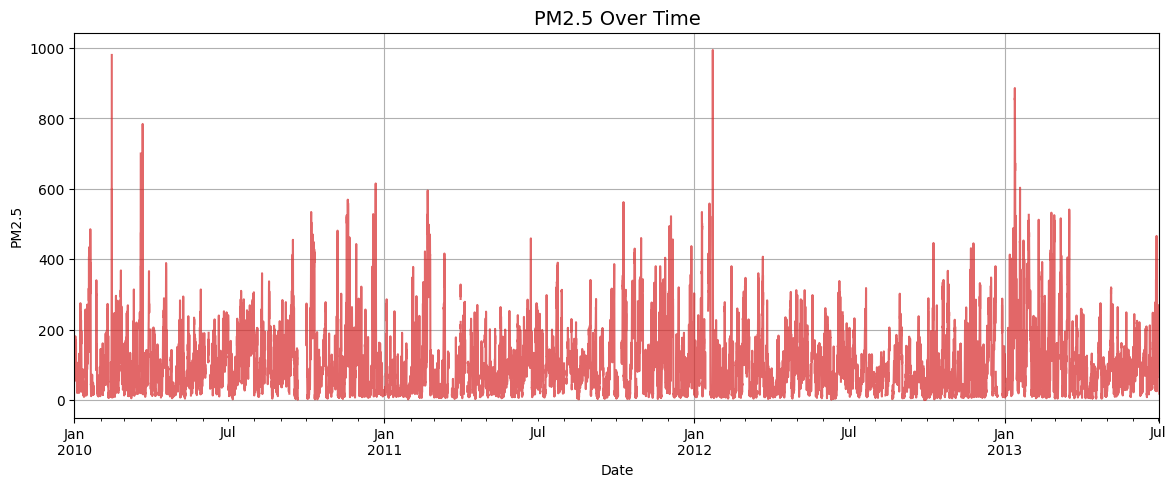

In [25]:
# plot of the target variable against time
comment('Shows a plot of PM2.5  vs time.\n The graph is blurry but it indicates the appearances of outliers and noise.\n Breaks in the line show the missing data in the target column.\n We can also get a sense that there is stationarity in the mean aroud 100.7 so  it suggests we don’t need heavy detrending or differencing\n just to “remove trend" in the data before passing it to the LSTM”')

plt.figure(figsize=(14,5))  # (width, height) in inches
train['pm2.5'].plot(color="tab:red", alpha=0.7)
plt.title("PM2.5 Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.grid(True)
plt.show()

==== Plotted a 7-day rolling average of PM2.5 over the original data to get better sense of underlying seasonality.
 The data still has spikes which means the data has a lot of short term variability.
 This could be due to varoius reasons such as waeather changes, human activity or random noise(eg errors etc)
 Noise can drown out true patterns, making it harder for the model to generalize
 And vry extreme outliers might not be normal behaviour
 We can use and  regularization and robust loss to avoid overfitting to noise  ====



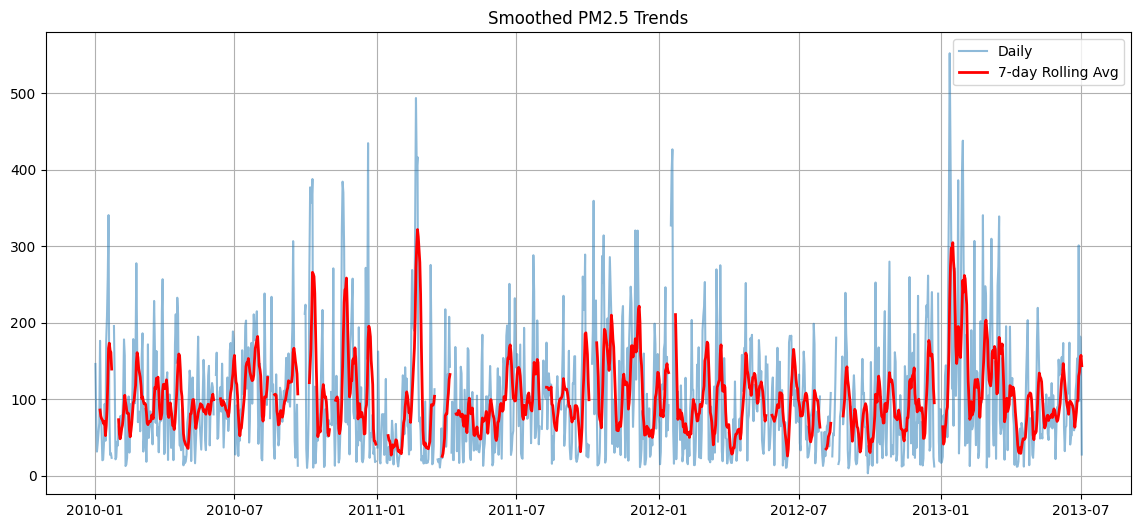

In [26]:
# plot of a target variable compared with its 7-day rolling average to pick u potential drowned out seasonality
comment("Plotted a 7-day rolling average of PM2.5 over the original data to get better sense of underlying seasonality.\n The data still has spikes which means the data has a lot of short term variability.\n This could be due to varoius reasons such as waeather changes, human activity or random noise(eg errors etc)\n Noise can drown out true patterns, making it harder for the model to generalize\n And vry extreme outliers might not be normal behaviour\n We can use and  regularization and robust loss to avoid overfitting to noise ")

daily = train['pm2.5'].resample('D').mean()
rolling = daily.rolling(window=7).mean()  # 7-day rolling avg

plt.figure(figsize=(14,6))
plt.plot(daily.index, daily, alpha=0.5, label="Daily")
plt.plot(daily.index, rolling, color="red", linewidth=2, label="7-day Rolling Avg")
plt.legend()
plt.title("Smoothed PM2.5 Trends")
plt.grid(True)
plt.show()

==== Comparing plots annual plots of pm2.5 to visually inspect any seasonality over the years,
 So far there is no coherent seasonality between the years and there are several fluctuations once again. Most of the values seem to be noise. ====



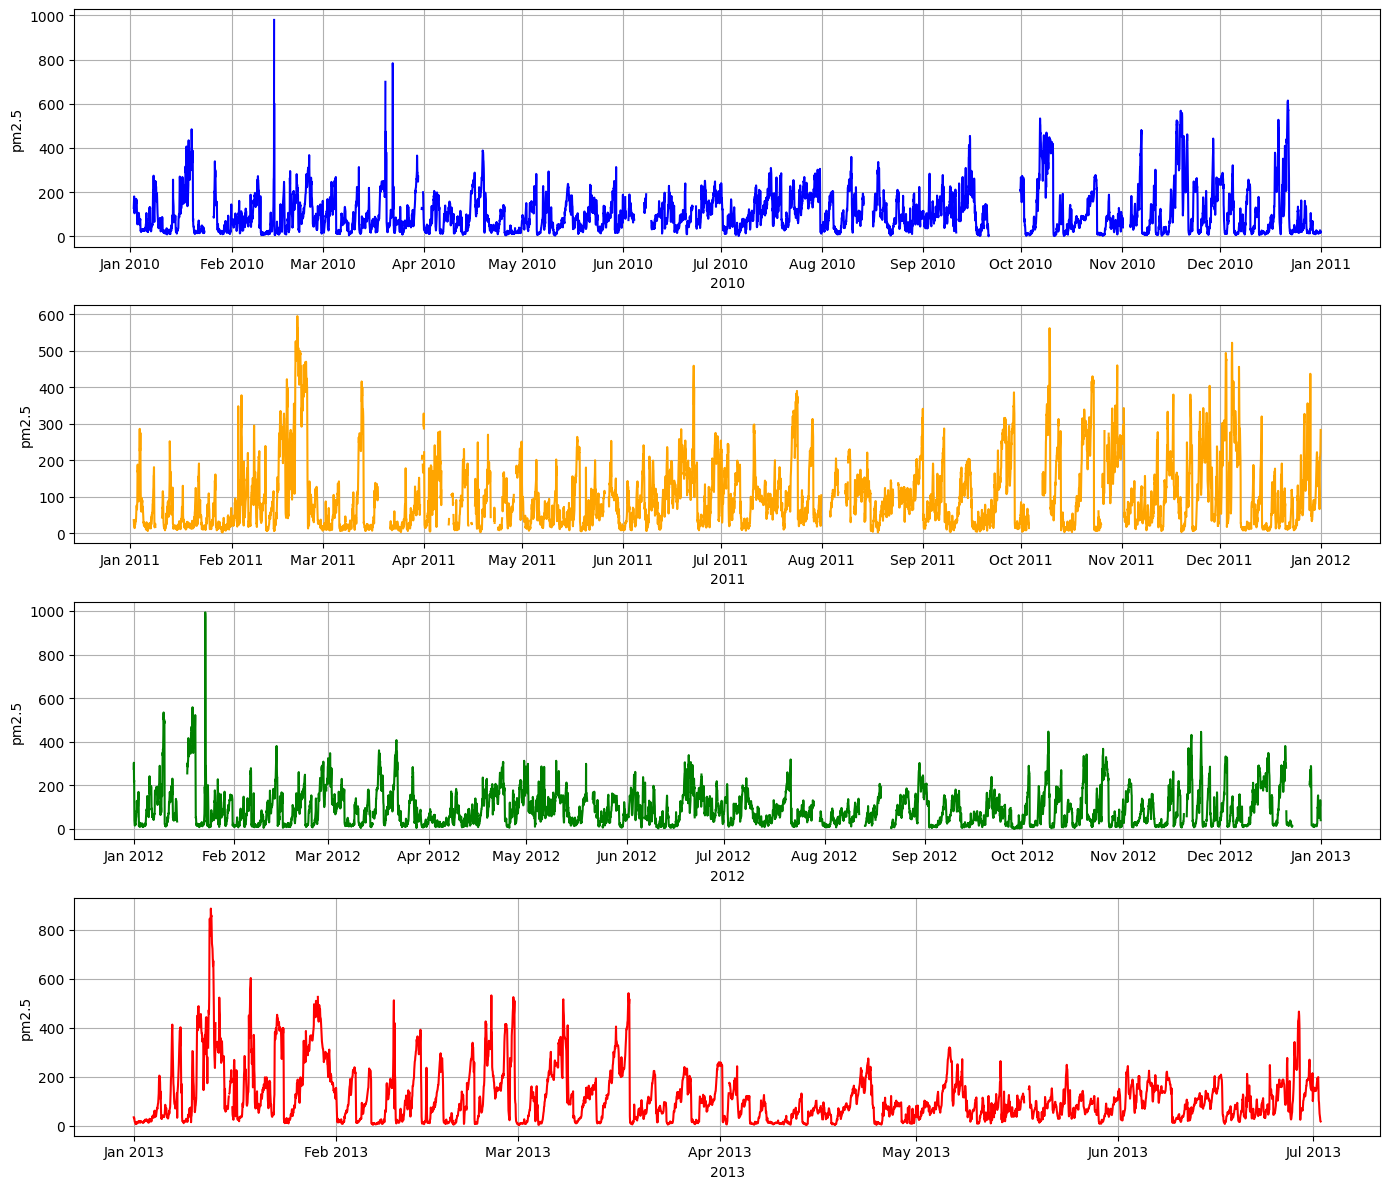

In [27]:
# comparison of plots of the target variable against time spanning one year to try to detect annual patterns

comment("Comparing plots annual plots of pm2.5 to visually inspect any seasonality over the years,\n So far there is no coherent seasonality between the years and there are several fluctuations once again. Most of the values seem to be noise.")

import matplotlib.dates as mdates
fig, axes = plt.subplots(4, 1, figsize=(14,12), sharex=False)

years = ['2010', '2011', '2012', '2013']
colors = ['blue', 'orange', 'green', 'red']

for i, year in enumerate(years):
  subset = train.loc[str(year)]
  axes[i].plot(subset.index, subset['pm2.5'], color = colors[i])
  axes[i].set_xlabel(str(year))
  axes[i].set_ylabel('pm2.5')
  axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
  axes[i].grid(True)


plt.tight_layout()
plt.show()

====  A lag plot is a scatter plot that shows the relationship between a time series and a lagged (shifted) version of itself.
 It will help detect patterns and autocorrelation in the data
 The data has high autocorrelation with a single previous variable, but from a 24 hr lag and above there is no discernable pattern
 This confirms the weak seasonality in the data
 but also suggests first order auto regression in the data. ====



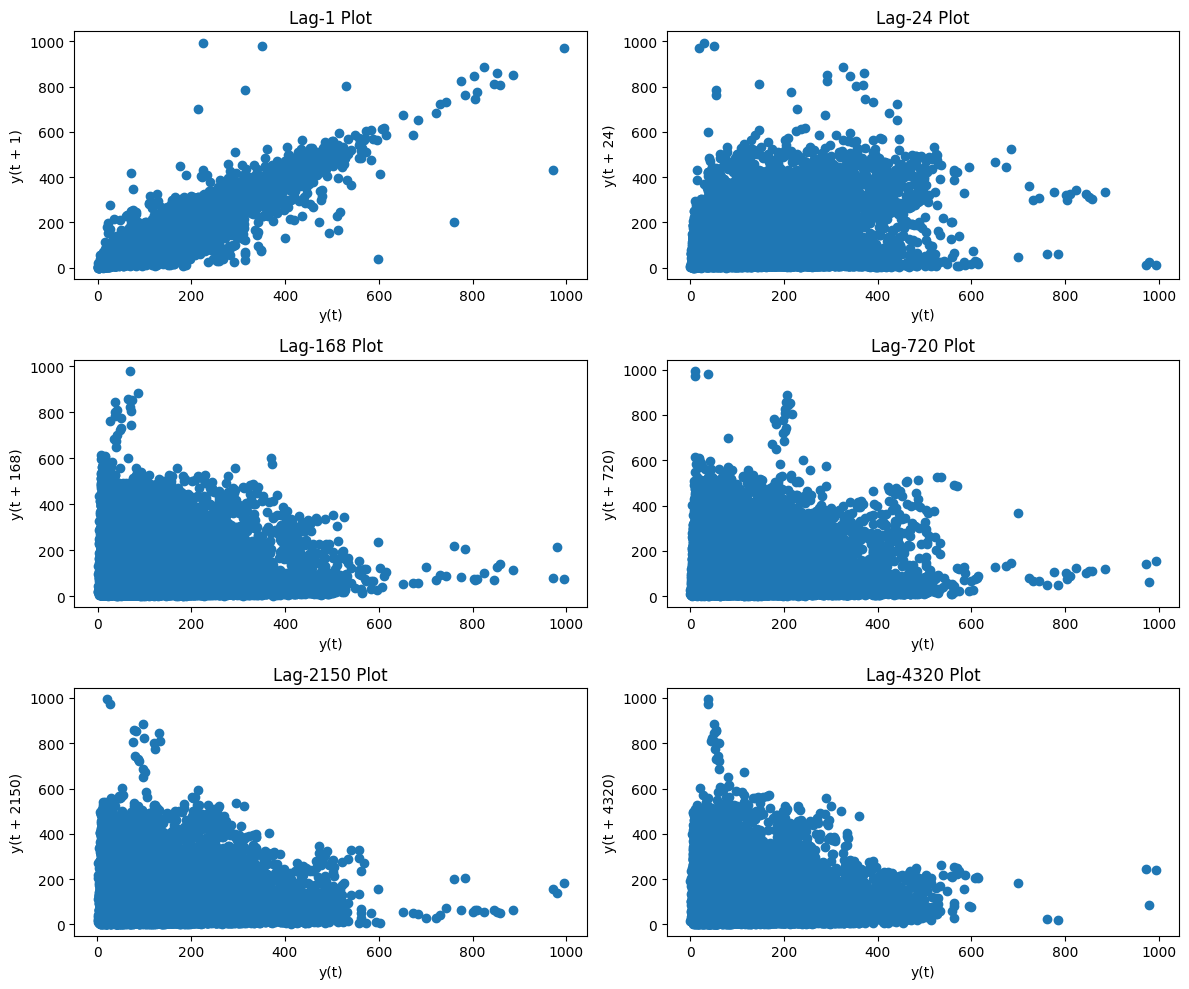

In [28]:
# lag plots to investigate potential auto-correlation in the target variable

comment(" A lag plot is a scatter plot that shows the relationship between a time series and a lagged (shifted) version of itself.\n It will help detect patterns and autocorrelation in the data\n The data has high autocorrelation with a single previous variable, but from a 24 hr lag and above there is no discernable pattern\n This confirms the weak seasonality in the data\n but also suggests first order auto regression in the data.")

from pandas.plotting import lag_plot
target = train['pm2.5']

# Multiple lags
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
lags = [1, 24, 168, 720, 2150, 4320]

for i, lag in enumerate(lags):
    plt.subplot(3, 2, i+1)
    lag_plot(target, lag=lag)
    plt.title(f'Lag-{lag} Plot')

plt.tight_layout()
plt.show()

==== These are ACF and PACF plots.
 FOR ACF: highest at lag 1, then gradually decreases.
 This tells us the series is auto-regressive(yesterday’s pm2.5 strongly influences today’s), and the effect fades gradually.
 But there are no large spike or peaks  at 24 hour intervals, which means there isn't a strict daily cycle,
 hours of the day as a new feature might still matter but the seasonality isnt clean.

 FOR PACF: The most direct (clean) predictors is the first lag.
 This confirms first order auto regression and suggest that my timesteps for my LSTM should be short (3-5timesteps)
 A Sharp dip to negative at lag 2, then hovering around zero
 which means that beyond 2 lags, extra past info doesn’t add much.
 I was considering adding lag features for the previos two timesteps to my dataset but i dont want to risk overfitting and redundancy ====



<Figure size 1200x500 with 0 Axes>

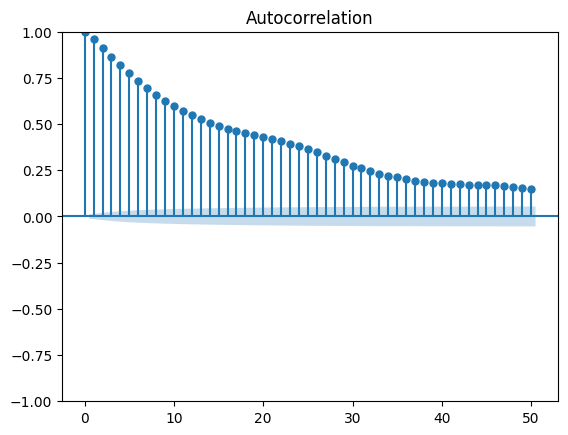

<Figure size 1200x500 with 0 Axes>

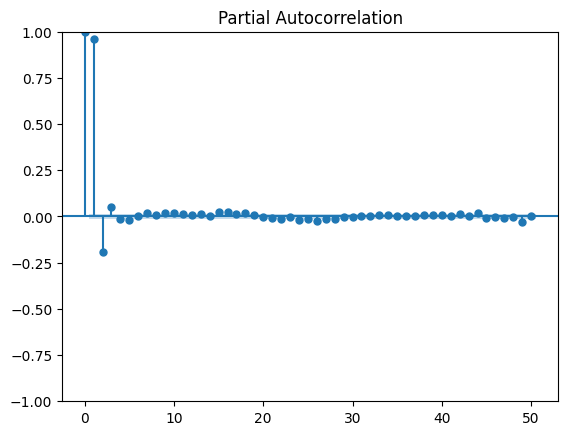

In [30]:
# ACF and PACF plots to confirm auto regression in the data and see how many past values contribute significantly to the current feature value

comment("These are ACF and PACF plots.\n FOR ACF: highest at lag 1, then gradually decreases.\n This tells us the series is auto-regressive(yesterday’s pm2.5 strongly influences today’s), and the effect fades gradually.\n But there are no large spike or peaks  at 24 hour intervals, which means there isn't a strict daily cycle,\n hours of the day as a new feature might still matter but the seasonality isnt clean.\n\n FOR PACF: The most direct (clean) predictors is the first lag.\n This confirms first order auto regression and suggest that my timesteps for my LSTM should be short (3-5timesteps)\n A Sharp dip to negative at lag 2, then hovering around zero\n which means that beyond 2 lags, extra past info doesn’t add much.\n I was considering adding lag features for the previos two timesteps to my dataset but i dont want to risk overfitting and redundancy")

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plot_acf(train['pm2.5'].dropna(), lags=50)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(train['pm2.5'].dropna(), lags=50)
plt.show()


==== Just checking the general distribution of the PM2.5 values.
 Most values not good air quality,
 indicating that our lstm output may be mostly values above 50μg/m³ as beijing is going through a spell of high air pollution, per the data.
 A log transform might be necessary to reduce the skewness of the target variable  ====



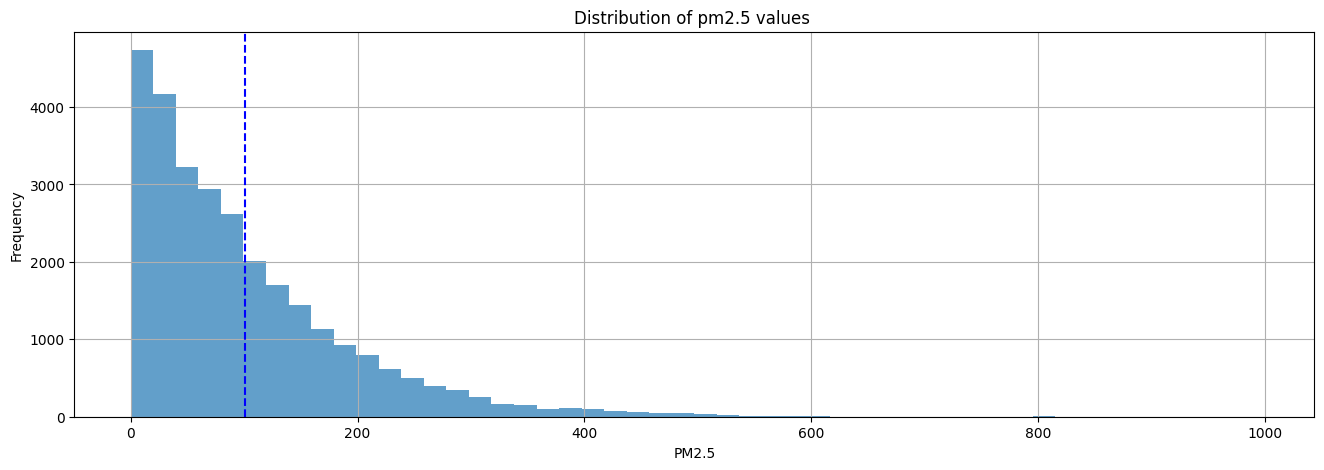

==== 0-50 μg/m³: Good air quality
 50-100 μg/m³: Moderate pollution
100+ μg/m³: Unhealthy levels ====



In [31]:
# distribution values in the target feature

comment("Just checking the general distribution of the PM2.5 values.\n Most values not good air quality,\n indicating that our lstm output may be mostly values above 50μg/m³ as beijing is going through a spell of high air pollution, per the data.\n A log transform might be necessary to reduce the skewness of the target variable ")

plt.figure(figsize=(16,5))
train['pm2.5'].dropna().hist(bins=50, color="tab:blue", alpha=0.7)
plt.title("Distribution of pm2.5 values ")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.axvline(train['pm2.5'].mean(), color='blue', linestyle='--', label='Mean')
plt.show()

"""0-50 μg/m³: Good air quality
50-100 μg/m³: Moderate pollution
100+ μg/m³: Unhealthy levels"""
comment('0-50 μg/m³: Good air quality\n 50-100 μg/m³: Moderate pollution\n100+ μg/m³: Unhealthy levels')

==== A correlation heat map to show relationships between features,
 On the correlation heatmap, there are  weak relationships with the target features with all variables with the strongest positive being 0.22
 and strongest negative being -0.23
 But these are linear relationships/ the lstm might pick up non linear relationships.  ====



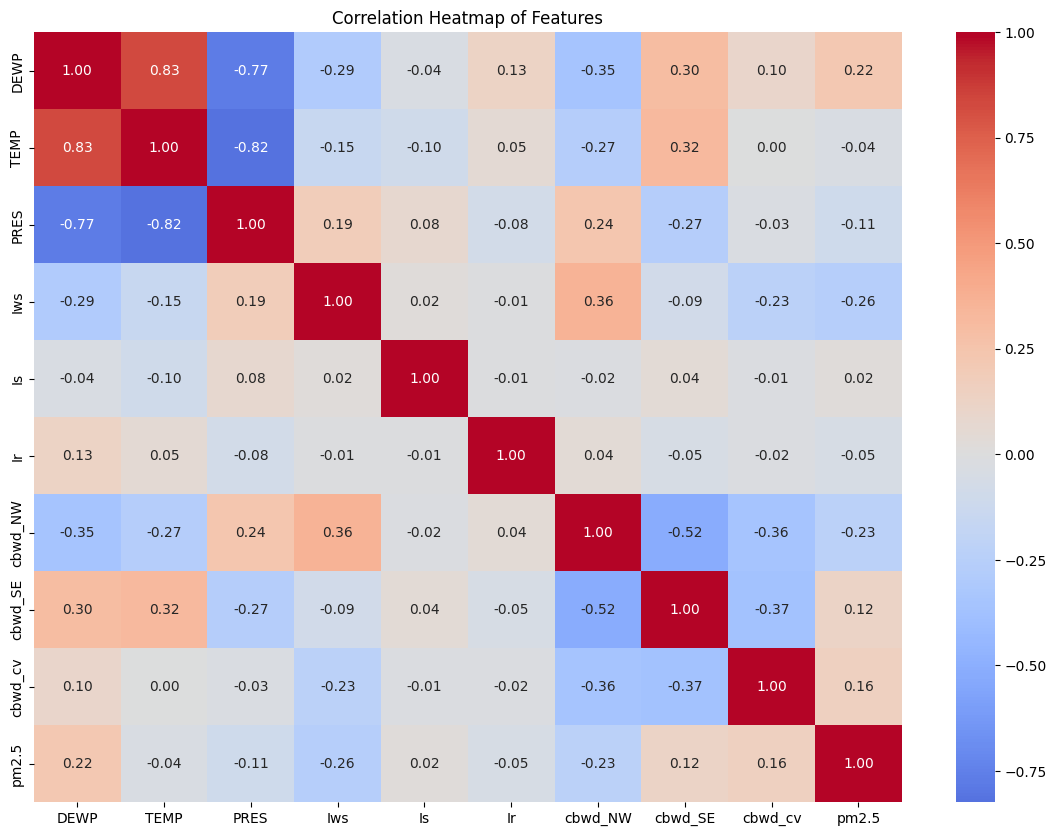

In [32]:
# correlation heatmap to visualize correlation between the features

comment("A correlation heat map to show relationships between features,\n On the correlation heatmap, there are  weak relationships with the target features with all variables with the strongest positive being 0.22\n and strongest negative being -0.23\n But these are linear relationships/ the lstm might pick up non linear relationships. ")
import seaborn as sns
plt.figure(figsize=(14,10))
corr = train.drop(columns=['No']).corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features")
plt.show()

In [33]:
# drop NaN variable temporarily for the auto correlation plot
train_na = train.copy()
train_na = train_na.dropna()

==== Autocorrelation plot confirming very week seasonality or trends in the data and poor autocorrelation between the target values the further back it goes ====



<Axes: xlabel='Lag', ylabel='Autocorrelation'>

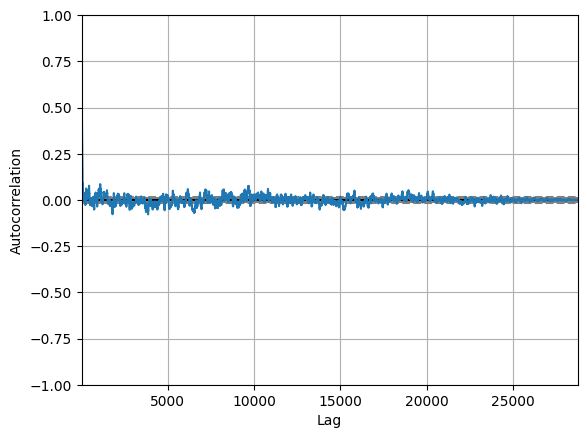

In [35]:
# Auto correlation plot to confirm weak seasonality across the entirre dataset
comment('Autocorrelation plot confirming very week seasonality or trends in the data and poor autocorrelation between the target values the further back it goes')
pd.plotting.autocorrelation_plot(train_na['2010':'2015']['pm2.5'])

# Actions to take per insights from data exploration

1. Regularization to avoid overfitting to noise and outliers in the dataset.
2. Feature engineering to include cyclical seasonal feature such as hours, days of the week, months etc. to help the model detect underlyling patterns drowned out by the noise if any.
3. Log transform target variable to reduc skewness in the data
4. Drop first 24 rows in the dataset as the target column consist of NaN values here
5. Use forward fill to fill all null values




# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [37]:
# drop first 24 columns all having null values
train_impute = train.copy()
train_impute = train_impute.iloc[24:]
train_impute.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-02 00:00:00,25,-1.234456,-1.348408,0.345943,-0.441894,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,129.0
2010-01-02 01:00:00,26,-1.165172,-1.348408,0.345943,-0.424097,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,148.0
2010-01-02 02:00:00,27,-0.888034,-1.430386,0.443328,-0.406301,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,159.0
2010-01-02 03:00:00,28,-0.610897,-1.430386,0.540712,-0.370508,1.245803,-0.137667,-0.690542,1.366085,-0.522096,181.0
2010-01-02 04:00:00,29,-0.610897,-1.430386,0.540712,-0.352712,2.560959,-0.137667,-0.690542,1.366085,-0.522096,138.0


In [38]:
# Use forward fill to fill null values based on the autoregressive nature of the values(far from perfect but it'll do)
train_impute['pm2.5'].fillna(method='ffill', inplace=True)
train_impute.isna().sum()

/tmp/ipython-input-188866775.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_impute['pm2.5'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-188866775.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_impute['pm2.5'].fillna(method='ffill', inplace=True)


,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [40]:
# function to include cyclical encoding of seasonal columns in the dataset
def cyclical_encoding(df):
  df['hour'] =  df.index.hour
  df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
  df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

  # Day of week (0–6)
  df['dayofweek'] = train_impute.index.dayofweek
  df['sin_dow'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
  df['cos_dow'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

  # Month (1–12)
  df['month'] =  df.index.month
  df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
  df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

  return df




In [43]:
# add new columns to the dataset
train_new_columns = cyclical_encoding(train_impute)
train_new_columns.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,sin_hour,cos_hour,dayofweek,sin_dow,cos_dow,month,sin_month,cos_month
datetime,,,,,,,,,,,,,,,,,,,,
2010-01-02 00:00:00,25,-1.234456,-1.348408,0.345943,-0.441894,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,129.0,0,0.000000,1.000000,5,-0.974928,-0.222521,1,0.5,0.866025
2010-01-02 01:00:00,26,-1.165172,-1.348408,0.345943,-0.424097,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,148.0,1,0.258819,0.965926,5,-0.974928,-0.222521,1,0.5,0.866025
2010-01-02 02:00:00,27,-0.888034,-1.430386,0.443328,-0.406301,-0.069353,-0.137667,-0.690542,1.366085,-0.522096,159.0,2,0.500000,0.866025,5,-0.974928,-0.222521,1,0.5,0.866025
2010-01-02 03:00:00,28,-0.610897,-1.430386,0.540712,-0.370508,1.245803,-0.137667,-0.690542,1.366085,-0.522096,181.0,3,0.707107,0.707107,5,-0.974928,-0.222521,1,0.5,0.866025
2010-01-02 04:00:00,29,-0.610897,-1.430386,0.540712,-0.352712,2.560959,-0.137667,-0.690542,1.366085,-0.522096,138.0,4,0.866025,0.500000,5,-0.974928,-0.222521,1,0.5,0.866025


In [45]:
# function to preprocess the dataset before lstm training
def preprocessing(df):
  from sklearn.preprocessing import MinMaxScaler
  # scale values between 0 and 1
  scaler_x = MinMaxScaler()
  scaler_y = MinMaxScaler()

  # separate features and targets
  X = df.drop(['pm2.5', 'No'], axis=1)
  y = df['pm2.5']

  # log transform target data to deal with skewness
  y_log = np.log1p(y)

  # Scale the data btw 0 and 1 using min max scaler to put all columns on the same scale

  X_scaled = scaler_x.fit_transform(X)

  # Reshape y_log to 2D array for the scaler

  y_scaled = scaler_y.fit_transform(y_log.values.reshape(-1, 1))
  # Convert back to 1D for LSTM
  y_scaled = y_scaled.flatten()

  # convert to numpy array
  X_array = np.array(X_scaled)
  y_array = np.array(y_scaled)

  return X_array, y_array



In [47]:
# preprocess training data
X_train, y_train = preprocessing(train_new_columns)
print(X_train.shape)
y_train.shape

(30652, 18)


(30652,)

In [ ]:
# feature engineering for cyclical encoding(day, day of the week and month) for time in the dataset, to help the model capture weak seasonality patterns better

# hour(1-24)
train_impute['hour'] =  train_impute.index.hour
train_impute['sin_hour'] = np.sin(2 * np.pi * train_impute['hour'] / 24)
train_impute['cos_hour'] = np.cos(2 * np.pi * train_impute['hour'] / 24)

# Day of week (0–6)
train_impute['dayofweek'] = train_impute.index.dayofweek
train_impute['sin_dow'] = np.sin(2 * np.pi * train_impute['dayofweek'] / 7)
train_impute['cos_dow'] = np.cos(2 * np.pi * train_impute['dayofweek'] / 7)

# Month (1–12)
train_impute['month'] =  train_impute.index.month
train_impute['sin_month'] = np.sin(2 * np.pi * train_impute['month'] / 12)
train_impute['cos_month'] = np.cos(2 * np.pi * train_impute['month'] / 12)

train_impute.columns

In [ ]:
# use scaler for
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:
# split training data into fatures and targets
X_train = train_impute.drop(['pm2.5', 'No'], axis=1)
y_train = train_impute['pm2.5']

# log transform target data to deal with skewness
y_log = np.log1p(y_train)

# Scale the data btw 0 and 1 using min max scaler to put all columns on the same scale

X_train_scaled = scaler_x.fit_transform(X_train)

# Reshape y_log to 2D array for the scaler

y_train_scaled = scaler_y.fit_transform(y_log.values.reshape(-1, 1))
# Convert back to 1D for LSTM

y_train_scaled = y_train_scaled.flatten()

In [ ]:
X_array = np.array(X_train_scaled)
y_array = np.array(y_train_scaled)

print(X_array.shape)
print(y_array.shape)

In [49]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).

# function to create timeseries sequesnces using Timeseries generator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
def create_timeseries(batch_size,X,y):
  generator = TimeseriesGenerator(X, y, length=5, sampling_rate=1, batch_size=batch_size, shuffle=False)

  return generator

In [51]:
# confirm creation of sequences with a batch size of 32
sequences = create_timeseries(32, X_train, y_train)
x_batch, y_batch = sequences[0]

print(x_batch.shape)
y_batch.shape

(32, 5, 18)


(32,)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [52]:
# function to build a vanilla LSTM
from tensorflow.keras.callbacks import EarlyStopping
def build_one_layer_lstm(units, generator, activation, window, n_features, dropout, optimizer, loss_function, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(window, n_features)))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
      optimizer=optimizer(learning_rate=learning_rate),
      loss=loss_function,
      metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

    early_stopping = EarlyStopping(
         patience = 20,
         restore_best_weights=True,
         verbose=1 )

    history = model.fit(generator, epochs=epochs, callbacks=[early_stopping], verbose=2)

    return model, history

In [53]:
# function to build a stacked lstm
def build_two_layer_lstm(units1, units2, generator, activation1, activation2, window, n_features, dropout1, dropout2, optimizer, loss_function, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(units1, activation=activation1, input_shape=(window, n_features),return_sequences=True))
    if dropout1 > 0:
        model.add(tf.keras.layers.Dropout(dropout1))
    model.add(LSTM(units2, activation=activation2,
               kernel_regularizer=tf.keras.regularizers.l2(0.01),
               recurrent_regularizer=tf.keras.regularizers.l1(0.005)))
    if dropout2 > 0:
        model.add(tf.keras.layers.Dropout(dropout2))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
      optimizer=optimizer(learning_rate=learning_rate),
      loss=loss_function,
      metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

    early_stopping = EarlyStopping(
         patience = 20,
         restore_best_weights=True,
         verbose=1 )

    history = model.fit(generator, epochs=epochs, callbacks=[early_stopping], verbose=2)

    return model, history

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping



generator = create_timeseries(32, X_train_scaled, y_train_scaled, 10)

def build_one_layer_lstm(units, generator, activation, window, n_features, dropout, optimizer, loss_function, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(units, activation=activation, input_shape=(window, n_features)))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
      optimizer=optimizer(learning_rate=learning_rate),
      loss=loss_function,
      metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

    early_stopping = EarlyStopping(
         patience = 20,
         restore_best_weights=True,
         verbose=1 )

    history = model.fit(generator, epochs=epochs, callbacks=[early_stopping], verbose=2)

    return model, history


def build_two_layer_lstm(units1, units2, generator, activation1, activation2, window, n_features, dropout1, dropout2, optimizer, loss_function, learning_rate, epochs):
    model = Sequential()
    model.add(LSTM(units1, activation=activation1, input_shape=(window, n_features),return_sequences=True))
    if dropout1 > 0:
        model.add(tf.keras.layers.Dropout(dropout1))
    model.add(LSTM(units2, activation=activation2,
               kernel_regularizer=tf.keras.regularizers.l2(0.01),
               recurrent_regularizer=tf.keras.regularizers.l1(0.005)))
    if dropout2 > 0:
        model.add(tf.keras.layers.Dropout(dropout2))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
      optimizer=optimizer(learning_rate=learning_rate),
      loss=loss_function,
      metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

    early_stopping = EarlyStopping(
         patience = 20,
         restore_best_weights=True,
         verbose=1 )

    history = model.fit(generator, epochs=epochs, callbacks=[early_stopping], verbose=2)

    return model, history



In [ ]:
# define model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(x_batch.shape[1], x_batch.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

In [ ]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32
)

In [ ]:
# Calculate training loss
train_predictions = model.predict(X_train_scaled)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [ ]:








# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/beijing_pm2.5_data/subm_fixed.csv', index=False)